# 1. 一些疑问
## 1.1 后续项目介绍
后面项目会有工程部署相关内容,第三个项目取消语音的原因

后续行业公开课《知识图谱入门与实践》、《对话机器人的产业实践方法》、《推荐搜索系统与用户行为》

## 1.2 工程真实的样子
不是算法的叠加，不像竞赛，更注重的是解决问题点能力

## 1.3 面试的敲门砖
面试和做项目的不同，面试更加注重的基础知识点掌握程度，理解深度

## 1.4 实际工作中的产品思维
产品思维才会让工作更有意义，少走弯路

## 1.5 团队合作
从项目合作中锻炼
是否有git讲解的需求

## 1.6 项目作业安排计划
|教学周|内容|
|-|-|
|WEEK4|seq2seq 训练模型、原理及代码实现|
|WEEK5|数据自动摘要模型预处理及分析|
|WEEK6|核心训练模型搭建|
|WEEK7|数据自动摘要模型预处理及分析|
|WEEK8|部署上线实践课|

每次实践课作业将以各个小步骤进行代码提交（以小组为单位提交），提交代码和问题时间定于10.9、10.16、10.23、10.30，在提交代码那周的周末研讨课上助教会针对代码和问题分组答疑。

## 1.7 本周作业安排
用seq2seq2搭建项目模型，实现从数据处理、seq2seq模型搭建、生成结果report全过程。

每组提交代码和问题时间为10.9号

# 2. Exploding and Vanishing Gradient Problem

## 2.1 RNN 
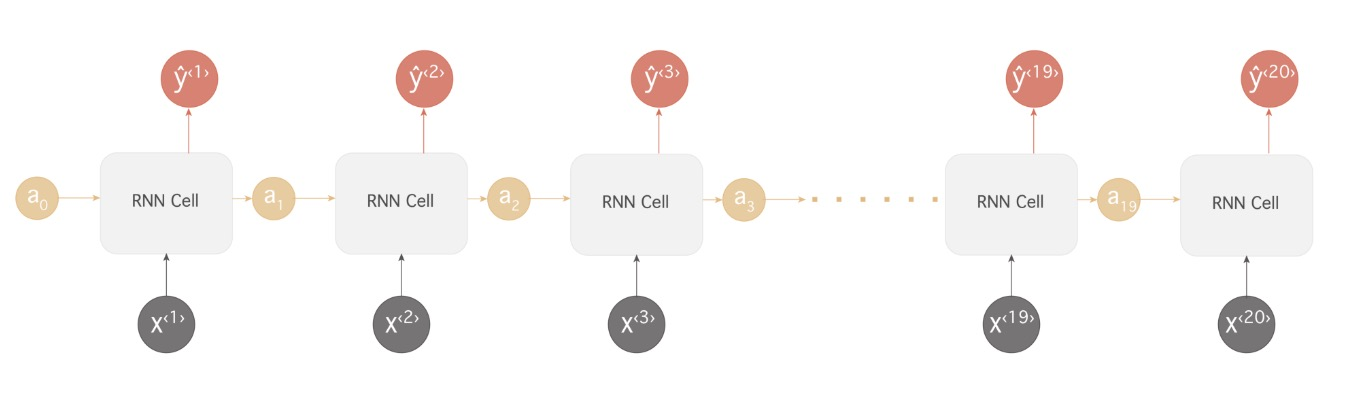

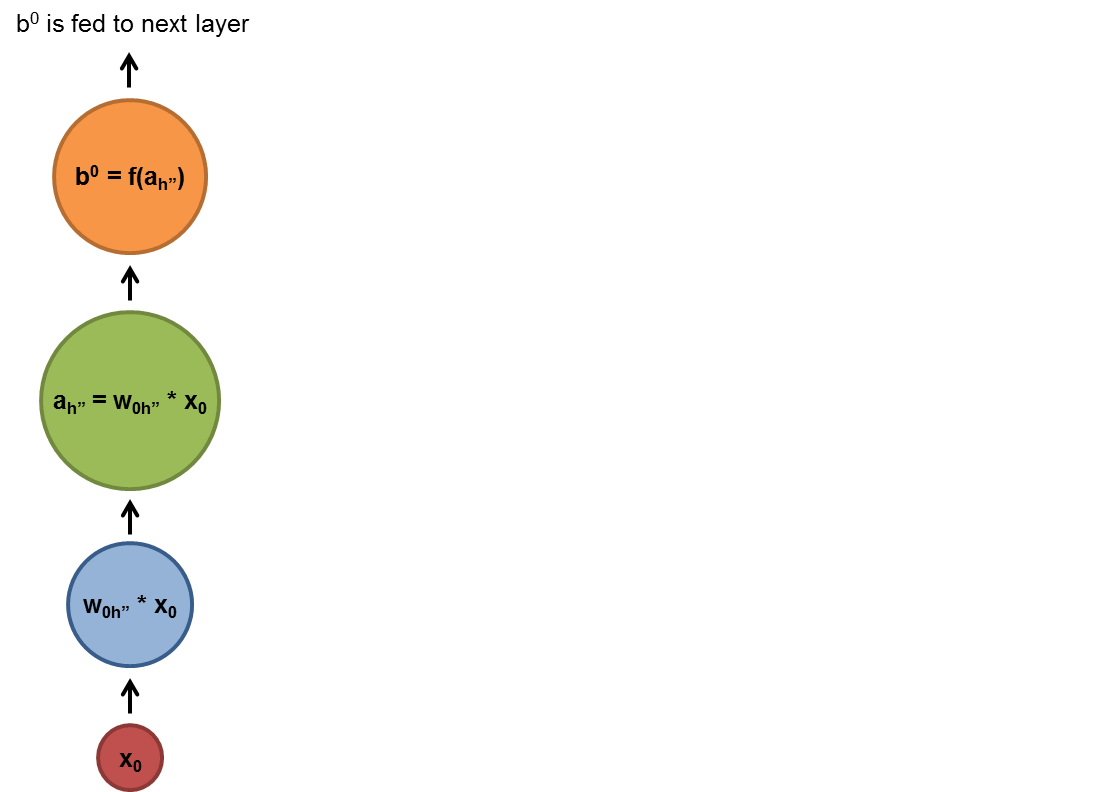


## 2.2 sigmoid function and its derivative.

Note how when the inputs of the sigmoid function becomes larger or smaller (when |x| becomes bigger), the derivative becomes close to zero.

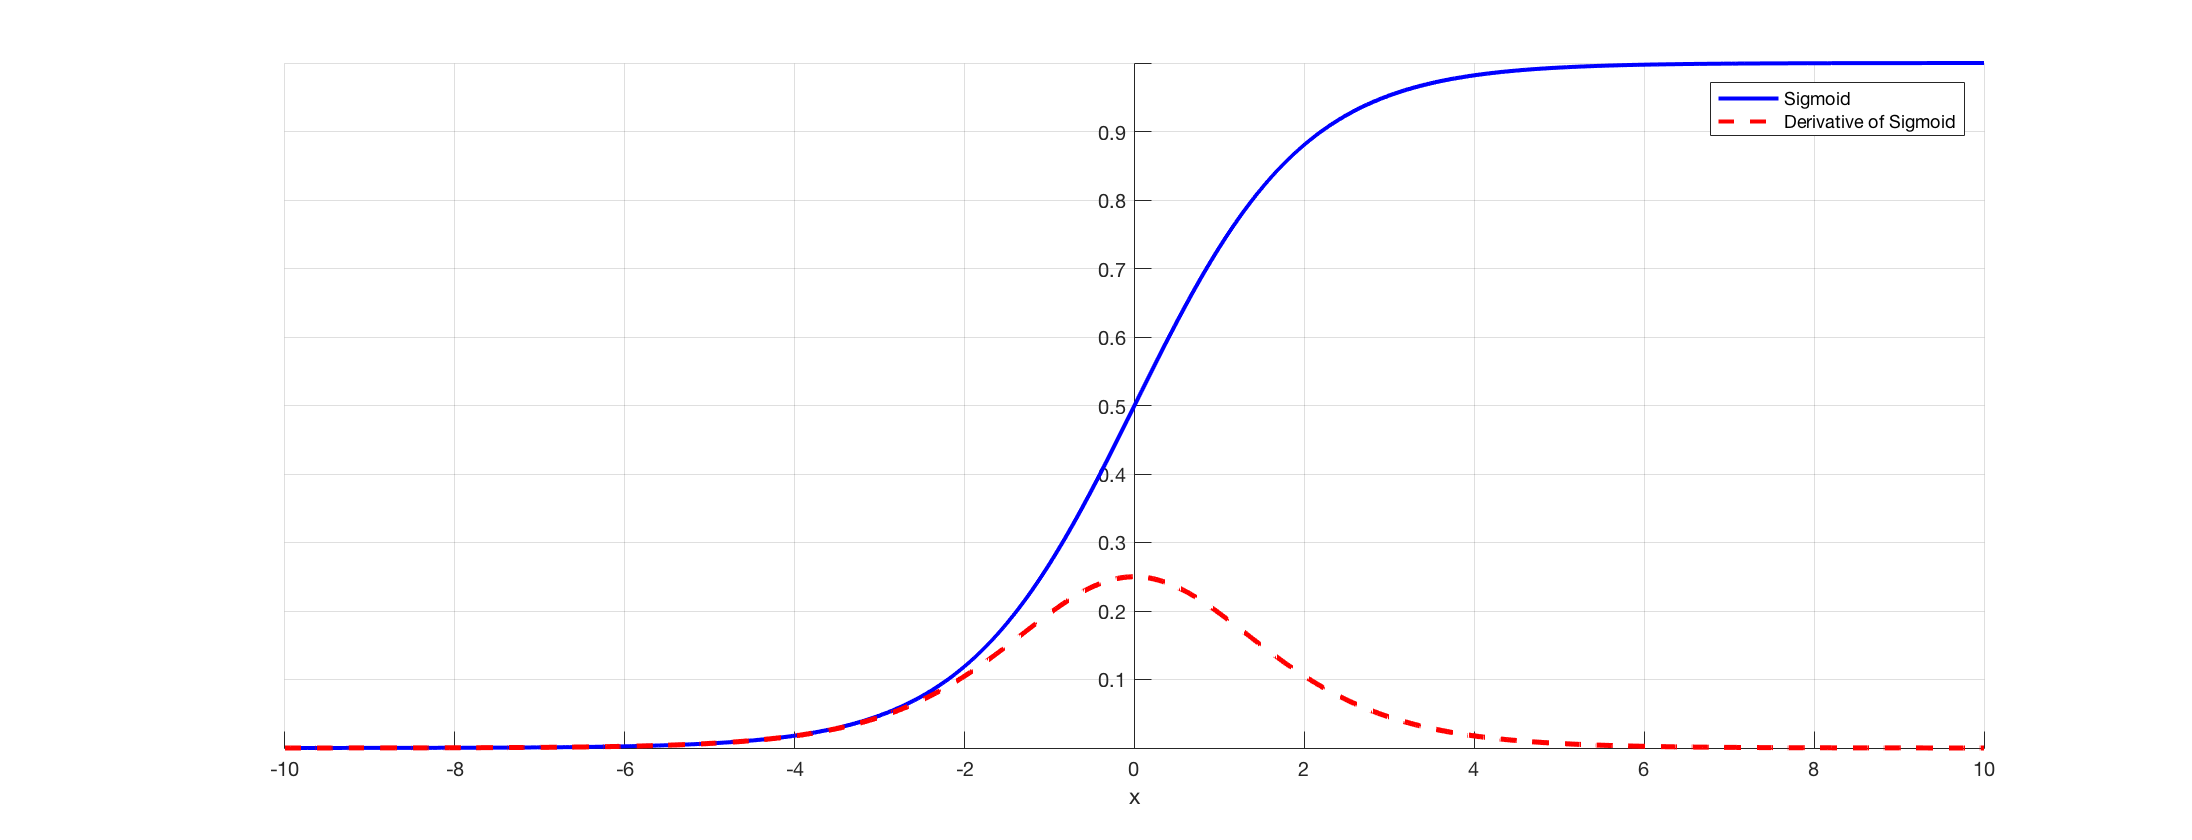

Gradients of neural networks are found using backpropagation. Simply put, backpropagation finds the derivatives of the network by moving layer by layer from the final layer to the initial one. By the chain rule, the derivatives of each layer are multiplied down the network (from the final layer to the initial) to compute the derivatives of the initial layers.
However, when n hidden layers use an activation like the sigmoid function, n small derivatives are multiplied together. Thus, the gradient decreases exponentially as we propagate down to the initial layers.

## 2.3 Exploding Gradient

Dealing with Exploding Gradients
A solution to fix this is to apply gradient clipping; which places a predefined threshold on the gradients to prevent it from getting too large, and by doing this it doesn’t change the direction of the gradients it only change its length.
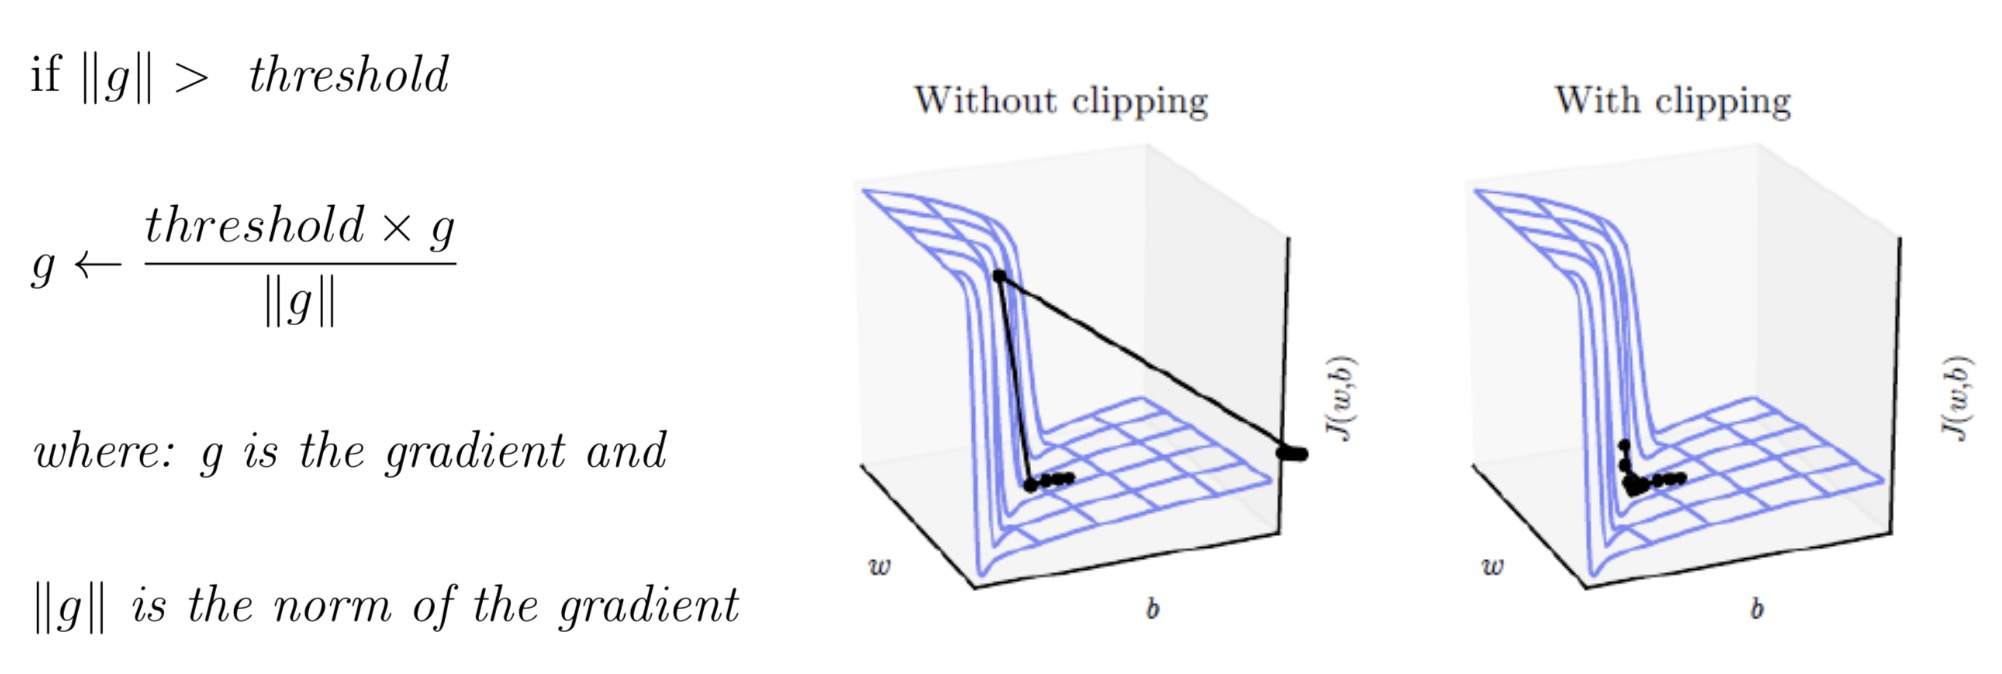

In [1]:
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)

## 2.4 Vanishing Gradient

### 2.4.1 Identity Initialization
 
One simple solution for dealing with vanishing gradient is the identity RNN architecture; where the network weights are initialized to the identity matrix and the activation functions are all set to ReLU and this ends up encouraging the network computations to stay close to the identity function. This works well because when the error derivatives are being propagated backwards through time, they remain constants of either 0 or 1, hence aren’t likely to suffer from vanishing gradients.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

(-1, 1)

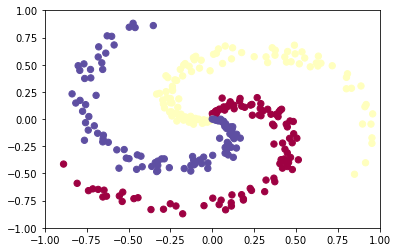

In [3]:
np.random.seed(0)
N = 100
D = 2
K = 3
X = np.zeros((N*K, D))
num_train_examples = X.shape[0]
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [4]:
def sigmoid(x):
    x = 1/(1+np.exp(-x))
    return x

def sigmoid_grad(x):
    return (x)*(1-x)

def relu(x):
    return np.maximum(0, x)

In [5]:
def three_layer_net(NONLINEARITY, X, y, model, step_size, reg):
    h = model['h']
    h2 = model['h2']
    W1 = model['W1']
    W2 = model['W2']
    W3 = model['W3']
    b1 = model['b1']
    b2 = model['b2']
    b3 = model['b3']
    
    num_examples = X.shape[0]
    plot_array_1 = []
    plot_array_2 = []
    for i in range(50000):
        if NONLINEARITY == 'RELU':
            hidden_layer = relu(np.dot(X, W1) + b1)
            hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3
        
        elif NONLINEARITY == 'SIGM':
            hidden_layer = sigmoid(np.dot(X, W1) + b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3
        
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        corect_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)+ 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print("iteration %d: loss %f" % (i, loss))
        
        dscores = probs
        dscores[range(num_examples), y] -= 1
        dscores /= num_examples
        
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)
        
        if NONLINEARITY == 'RELU':
            dhidden2 = np.dot(dscores, W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 = np.dot(hidden_layer.T, dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = np.dot(dhidden2, W2.T)
            dhidden[hidden_layer <= 0] = 0
            
        elif NONLINEARITY == 'SIGM':
            dhidden2 = dscores.dot(W3.T)*sigmoid_grad(hidden_layer2)
            dW2 = (hidden_layer.T).dot(dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = dhidden2.dot(W2.T)*sigmoid_grad(hidden_layer)
            
        dW1 =  np.dot(X.T, dhidden)
        plot_array_1.append(np.sum(np.abs(dW1))/np.sum(np.abs(dW1.shape)))
        db1 = np.sum(dhidden, axis=0)
        
        # add regularization
        dW3 += reg * W3
        dW2 += reg * W2
        dW1 += reg * W1
        
        #option to return loss, grads -- uncomment next comment
        grads = {}
        grads['W1'] = dW1
        grads['W2'] = dW2
        grads['W3'] = dW3
        grads['b1'] = db1
        grads['b2'] = db2
        grads['b3'] = db3
        #return loss, grads
        
        # update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
        
    # evaluate training set accuracy
    if NONLINEARITY == 'RELU':
        hidden_layer = relu(np.dot(X, W1) + b1)
        hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
    elif NONLINEARITY == 'SIGM':
        hidden_layer = sigmoid(np.dot(X, W1) + b1)
        hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
    
    scores = np.dot(hidden_layer2, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    print('training accuracy: %.2f' % (np.mean(predicted_class == y))) 
    #return cost, grads
    return plot_array_1, plot_array_2, W1, W2, W3, b1, b2, b3

In [6]:
#Initialize toy model, train sigmoid net

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
h = 50
h2 = 50
num_train_examples = X.shape[0]

model = {}
model['h'] = h # size of hidden layer 1
model['h2'] = h2 # size of hidden layer 2
model['W1'] = 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2'] = np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(sigm_array_1, sigm_array_2, s_W1, s_W2,s_W3, s_b1, s_b2,s_b3) = three_layer_net('SIGM', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.156405
iteration 1000: loss 1.100737
iteration 2000: loss 0.999698
iteration 3000: loss 0.855495
iteration 4000: loss 0.819427
iteration 5000: loss 0.814825
iteration 6000: loss 0.810526
iteration 7000: loss 0.805943
iteration 8000: loss 0.800688
iteration 9000: loss 0.793976
iteration 10000: loss 0.783201
iteration 11000: loss 0.759909
iteration 12000: loss 0.719792
iteration 13000: loss 0.683194
iteration 14000: loss 0.655847
iteration 15000: loss 0.634996
iteration 16000: loss 0.618527
iteration 17000: loss 0.602246
iteration 18000: loss 0.579710
iteration 19000: loss 0.546264
iteration 20000: loss 0.512831
iteration 21000: loss 0.492403
iteration 22000: loss 0.481854
iteration 23000: loss 0.475923
iteration 24000: loss 0.472031
iteration 25000: loss 0.469086
iteration 26000: loss 0.466611
iteration 27000: loss 0.464386
iteration 28000: loss 0.462306
iteration 29000: loss 0.460319
iteration 30000: loss 0.458398
iteration 31000: loss 0.456528
iteration 32000: loss

In [7]:
#Re-initialize model, train relu net

model = {}
model['h'] = h # size of hidden layer 1
model['h2'] = h2# size of hidden layer 2
model['W1'] = 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2'] = np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(relu_array_1, relu_array_2, r_W1, r_W2,r_W3, r_b1, r_b2,r_b3) = three_layer_net('RELU', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.116188
iteration 1000: loss 0.275047
iteration 2000: loss 0.152297
iteration 3000: loss 0.136370
iteration 4000: loss 0.130853
iteration 5000: loss 0.127878
iteration 6000: loss 0.125951
iteration 7000: loss 0.124599
iteration 8000: loss 0.123502
iteration 9000: loss 0.122594
iteration 10000: loss 0.121833
iteration 11000: loss 0.121202
iteration 12000: loss 0.120650
iteration 13000: loss 0.120165
iteration 14000: loss 0.119734
iteration 15000: loss 0.119345
iteration 16000: loss 0.119000
iteration 17000: loss 0.118696
iteration 18000: loss 0.118423
iteration 19000: loss 0.118166
iteration 20000: loss 0.117932
iteration 21000: loss 0.117718
iteration 22000: loss 0.117521
iteration 23000: loss 0.117337
iteration 24000: loss 0.117168
iteration 25000: loss 0.117011
iteration 26000: loss 0.116863
iteration 27000: loss 0.116721
iteration 28000: loss 0.116574
iteration 29000: loss 0.116427
iteration 30000: loss 0.116293
iteration 31000: loss 0.116164
iteration 32000: loss

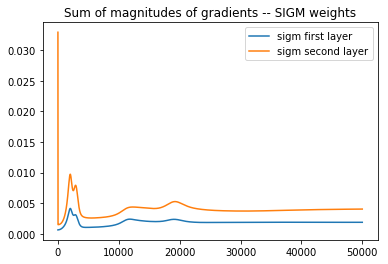

In [8]:
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- SIGM weights')
plt.legend(("sigm first layer", "sigm second layer"))

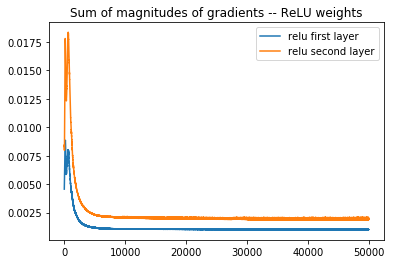

In [9]:
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.title('Sum of magnitudes of gradients -- ReLU weights')
plt.legend(("relu first layer", "relu second layer"))

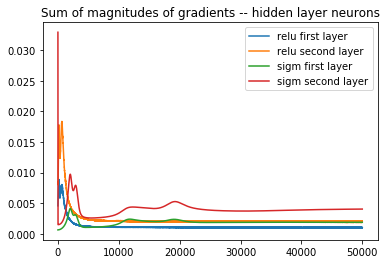

In [10]:
# Overlaying the two plots to compare
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- hidden layer neurons')
plt.legend(("relu first layer", "relu second layer","sigm first layer", "sigm second layer"))

(-1.8712034092398278, 1.8687965907601756)

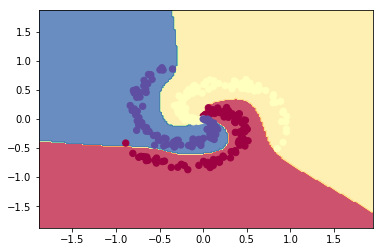

In [11]:
# plot the classifiers- SIGMOID
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(sigmoid(np.dot(sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], s_W1) + s_b1), s_W2) + s_b2), s_W3) + s_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

(-1.8712034092398278, 1.8687965907601756)

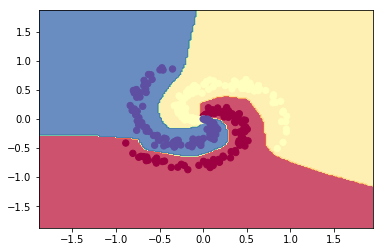

In [12]:
# plot the classifiers-- RELU
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(relu(np.dot(relu(np.dot(np.c_[xx.ravel(), yy.ravel()], r_W1) + r_b1), r_W2) + r_b2), r_W3) + r_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

### 2.4.2 LSTM

An even more popular and widely used solution is the Long Short-Term Memory architecture (LSTM); a variant of the regular recurrent network which was designed to make it easy to capture long-term dependencies in sequence data. The standard RNN operates in such a way that the hidden state activation are influenced by the other local activations closest to them, which corresponds to a “short-term memory”, while the network weights are influenced by the computations that take place over entire long sequences, which corresponds to a “long-term memory”. Hence the RNN was redesigned so that it has an activation state that can also act like weights and preserve information over long distances, hence the name “Long Short-Term Memory”.

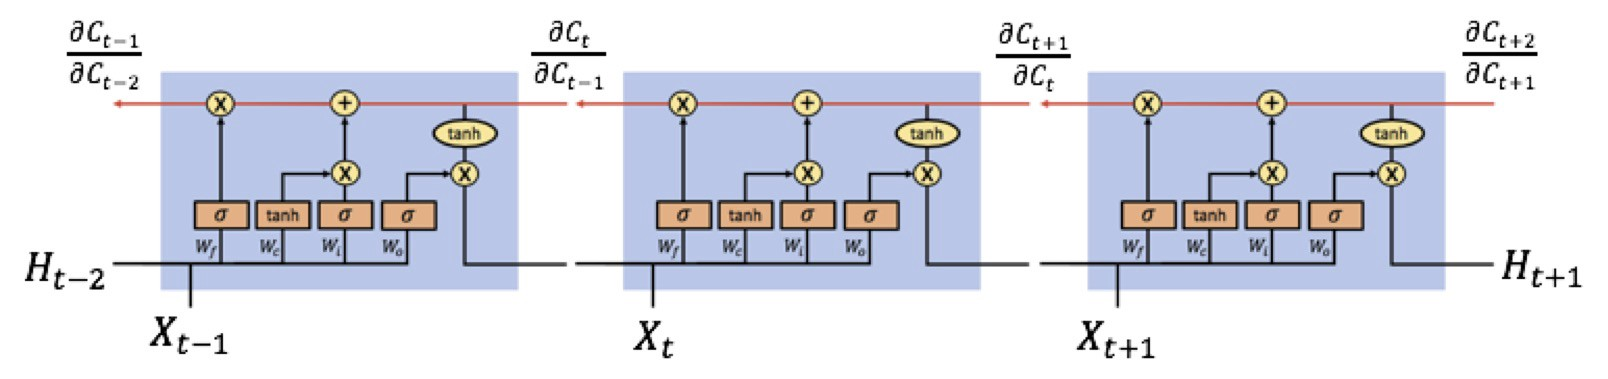

### 2.4.3 Residual Networks

Residual networks are another solution, as they provide residual connections straight to earlier layers. As seen in Image 2, the residual connection directly adds the value at the beginning of the block, x, to the end of the block (F(x)+x). This residual connection doesn’t go through activation functions that “squashes” the derivatives, resulting in a higher overall derivative of the block.

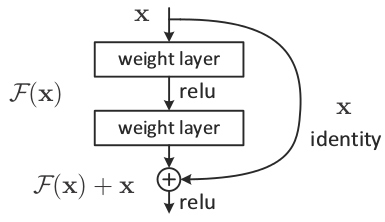

### 2.4.4 Batch Normalization

Finally, batch normalization layers can also resolve the issue. As stated before, the problem arises when a large input space is mapped to a small one, causing the derivatives to disappear. In Image 1, this is most clearly seen at when |x| is big. Batch normalization reduces this problem by simply normalizing the input so |x| doesn’t reach the outer edges of the sigmoid function. As seen in Image 3, it normalizes the input so that most of it falls in the green region, where the derivative isn’t too small.

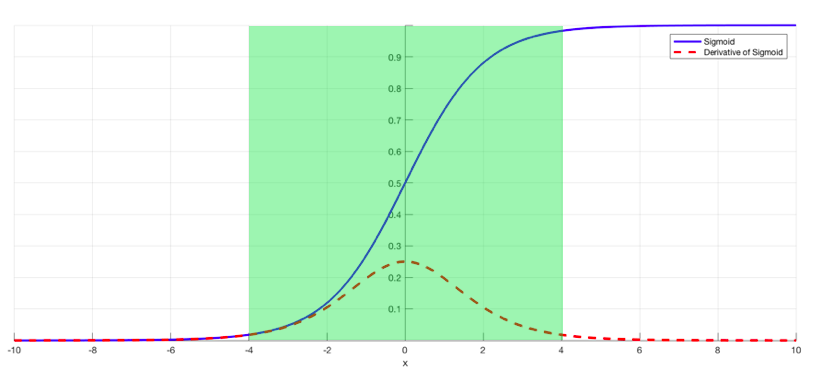

In [14]:
from tensorflow import keras

keras.layers.BatchNormalization(axis=-1,
                                momentum=0.99,
                                epsilon=0.001,
                                center=True,
                                scale=True,
                                beta_initializer='zeros',
                                gamma_initializer='ones',
                                moving_mean_initializer='zeros',
                                moving_variance_initializer='ones',
                                beta_regularizer=None,
                                gamma_regularizer=None,
                                beta_constraint=None,
                                gamma_constraint=None)


# 3. LSTM and GRU

## 3.1 LSTM

### 3.1.1 Forget Gate

The first step in our LSTM is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “forget gate layer.” It looks at h<sub>t−1</sub> and x<sub>t</sub>, and outputs a number between 0 and 1 for each number in the cell state C<sub>t−1</sub>. A 1 represents “completely keep this” while a 0 represents “completely get rid of this.”

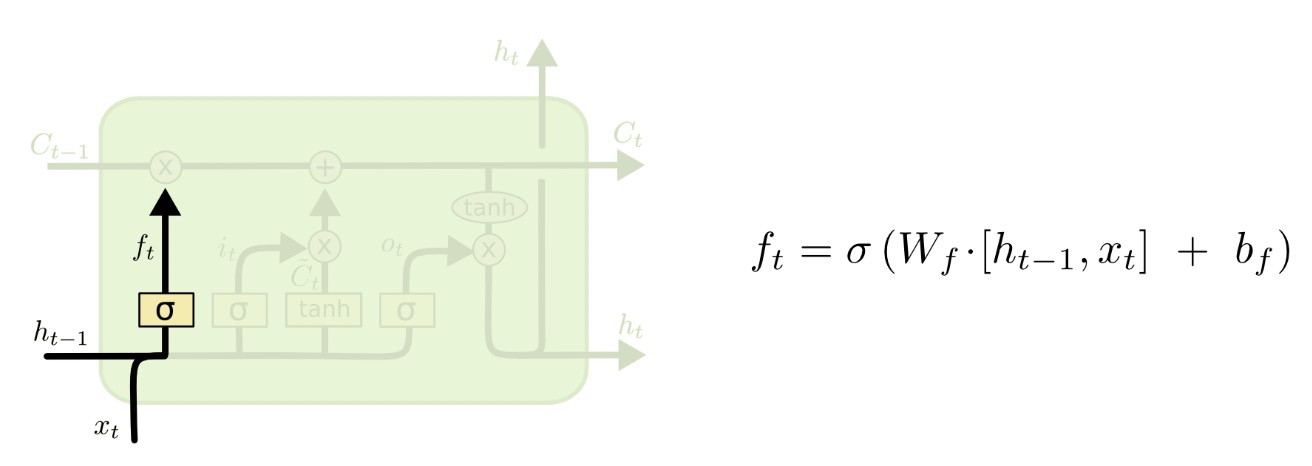

### 3.1.2 Input Gate

The next step is to decide what new information we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “input gate layer” decides which values we’ll update. Next, a tanh layer creates a vector of new candidate values, C̃<sub>t</sub>, that could be added to the state. In the next step, we’ll combine these two to create an update to the state.

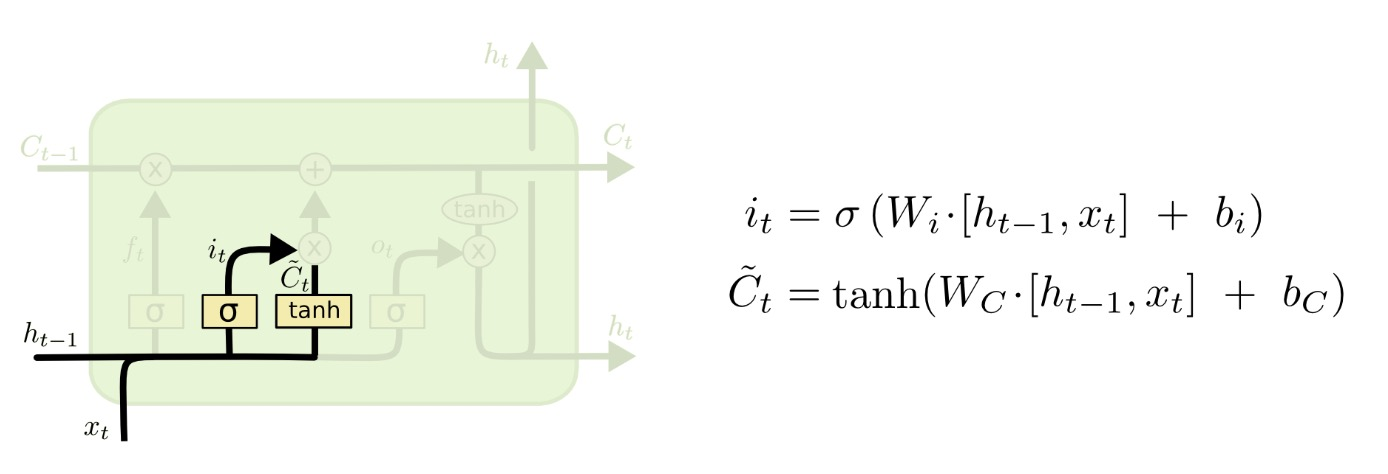

It’s now time to update the old cell state, C<sub>t-1</sub>, into the new cell state C<sub>t</sub>. The previous steps already decided what to do, we just need to actually do it.

We multiply the old state by f<sub>t</sub>, forgetting the things we decided to forget earlier. Then we add i<sub>t</sub>∗C̃<sub>t</sub>. This is the new candidate values, scaled by how much we decided to update each state value.

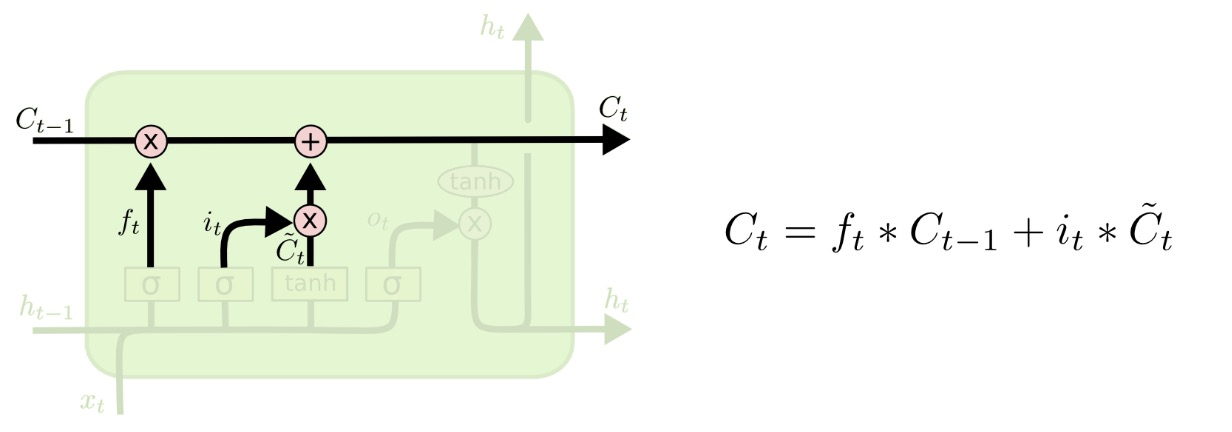

### 3.1.3 Output Gate

Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.

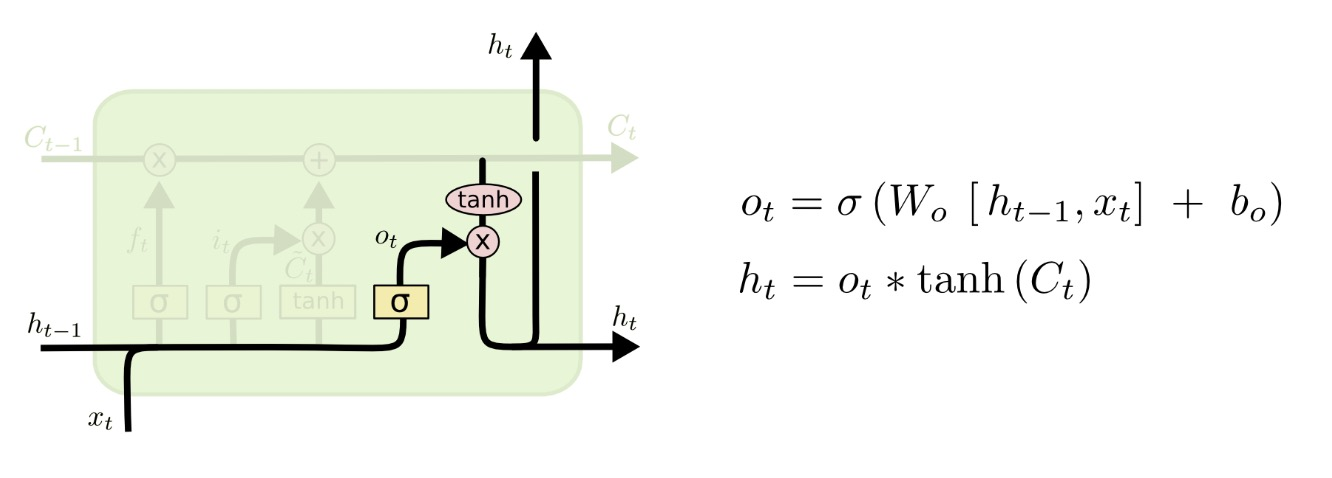

## 3.2 GRU

A slightly more dramatic variation on the LSTM is the Gated Recurrent Unit, or GRU, introduced by Cho, et al. (2014). It combines the forget and input gates into a single “update gate.” It also merges the cell state and hidden state, and makes some other changes. The resulting model is simpler than standard LSTM models, and has been growing increasingly popular.

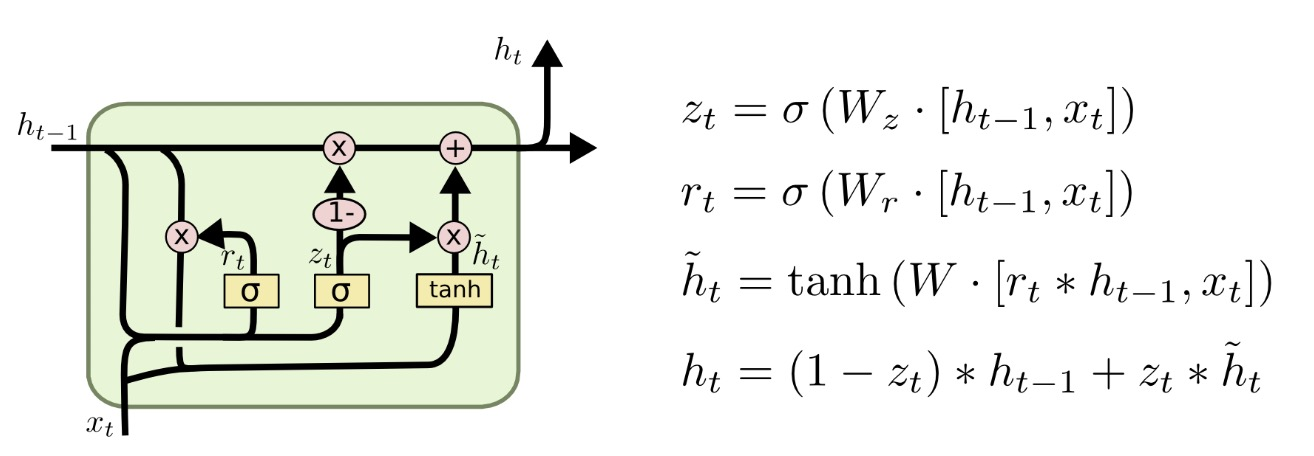

In [15]:
# output, state_h, state_c = self.lstm(x)
# output, state = self.gru(x)

## 3.3 Difference

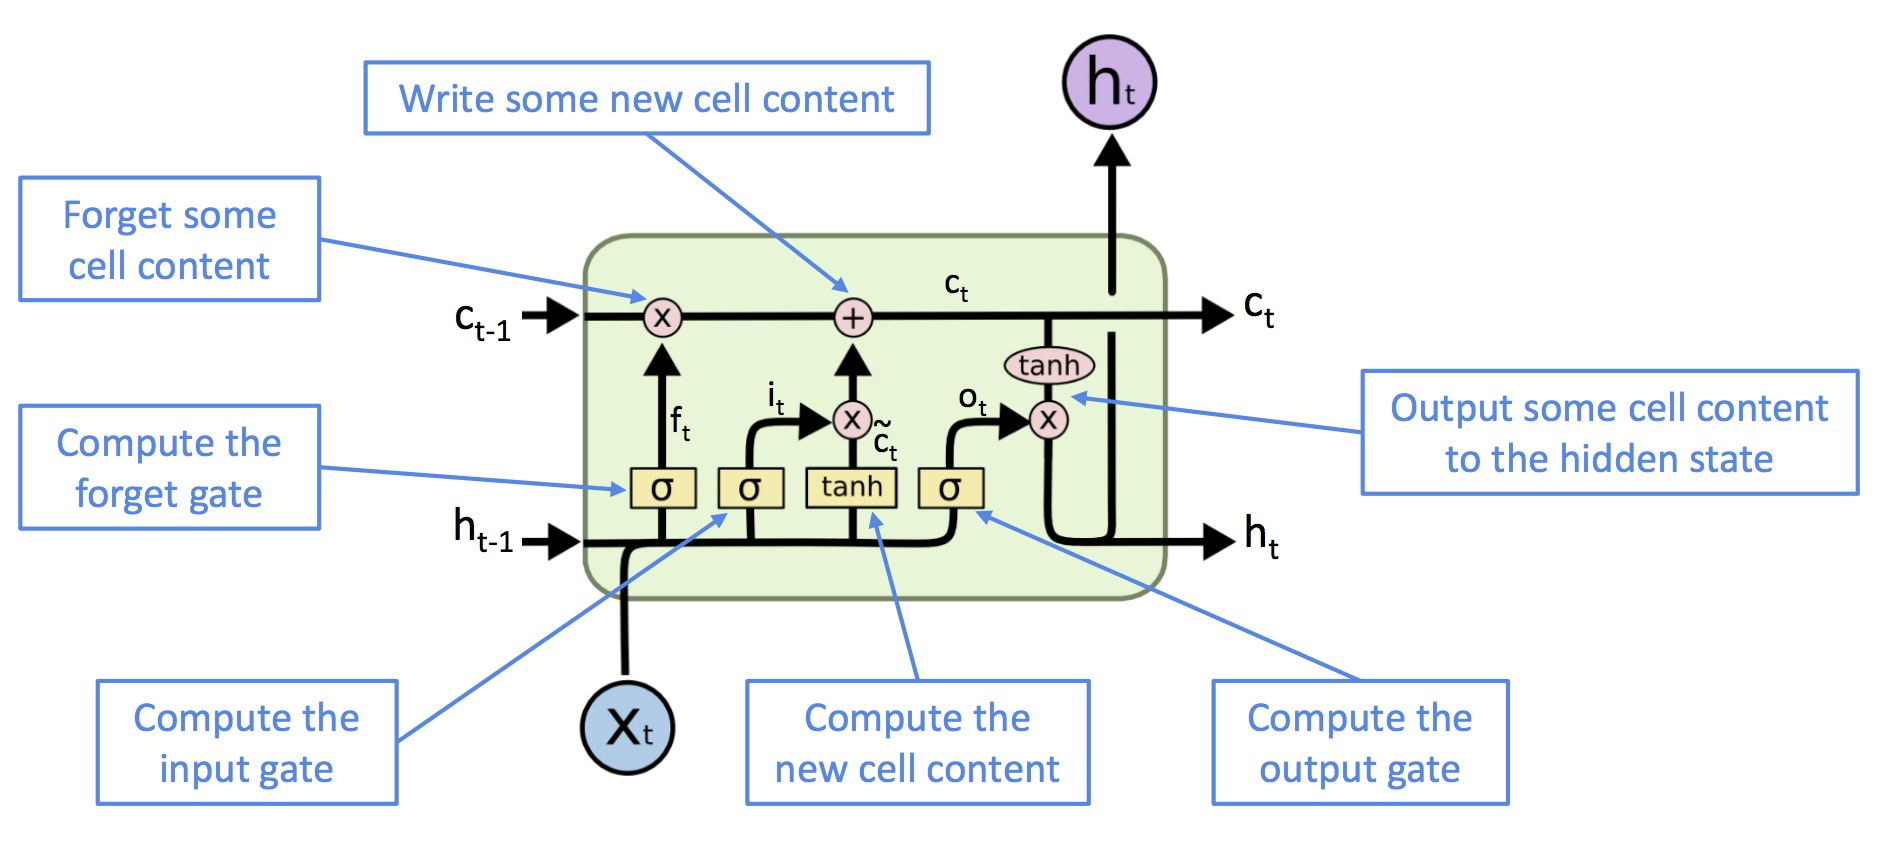

1) The biggest difference is that GRU is quicker to compute and has fewer parameters

2) There is no conclusive evidence that one consistently performs better than the other

3) LSTM is a good default choice (especially if your data has particularly long dependencies, or you have lots of training data)

4) Rule of thumb: start with LSTM, but switch to GRU if you want something more efficient

# 4. BLEU

The general task of sequence to sequence modelling is at the heart of some of the most difficult tasks in NLP,including:

Text summarization

Text simplification

Question answering

Chatbots

Machine translation

While there have been a lot of discussions of BLEU’s drawbacks, my top four issues with it are:

It doesn’t consider meaning

It doesn’t directly consider sentence structure

It doesn’t handle morphologically rich languages well

It doesn’t map well to human judgements

In [16]:
def BLEU(candidate, references):
    precisions = []
    for i in range(4):
        pr, bp = count_ngram(candidate, references, i+1)
        precisions.append(pr)
    bleu = geometric_mean(precisions) * bp
    return bleu

In [17]:
def count_ngram(candidate, references, n):
    clipped_count = 0
    count = 0
    r = 0
    c = 0
    for si in range(len(candidate)):
        # Calculate precision for each sentence
        ref_counts = []
        ref_lengths = []
        # Build dictionary of ngram counts
        for reference in references:
            ref_sentence = reference[si]
            ngram_d = {}
            words = ref_sentence.strip().split()
            ref_lengths.append(len(words))
            limits = len(words) - n + 1
            # loop through the sentance consider the ngram length
            for i in range(limits):
                ngram = ' '.join(words[i:i+n]).lower()
                if ngram in ngram_d.keys():
                    ngram_d[ngram] += 1
                else:
                    ngram_d[ngram] = 1
            ref_counts.append(ngram_d)
        # candidate
        cand_sentence = candidate[si]
        cand_dict = {}
        words = cand_sentence.strip().split()
        limits = len(words) - n + 1
        for i in range(0, limits):
            ngram = ' '.join(words[i:i + n]).lower()
            if ngram in cand_dict:
                cand_dict[ngram] += 1
            else:
                cand_dict[ngram] = 1
        clipped_count += clip_count(cand_dict, ref_counts)
        count += limits
        r += best_length_match(ref_lengths, len(words))
        c += len(words)
    if clipped_count == 0:
        pr = 0
    else:
        pr = float(clipped_count) / count
    bp = brevity_penalty(c, r)
    return pr, bp

In [18]:
def clip_count(cand_d, ref_ds):
    """Count the clip count for each ngram considering all references"""
    count = 0
    for m in cand_d.keys():
        m_w = cand_d[m]
        m_max = 0
        for ref in ref_ds:
            if m in ref:
                m_max = max(m_max, ref[m])
        m_w = min(m_w, m_max)
        count += m_w
    return count

In [19]:
def best_length_match(ref_l, cand_l):
    """Find the closest length of reference to that of candidate"""
    least_diff = abs(cand_l-ref_l[0])
    best = ref_l[0]
    for ref in ref_l:
        if abs(cand_l-ref) < least_diff:
            least_diff = abs(cand_l-ref)
            best = ref
    return best

In [20]:
def brevity_penalty(c, r):
    if c > r:
        bp = 1
    else:
        bp = math.exp(1-(float(r)/c))
    return bp

In [21]:
def geometric_mean(precisions):
    return (reduce(operator.mul, precisions)) ** (1.0 / len(precisions))

# 5. 自定义layer和model

In [22]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [27]:
class MyLayer(layers.Layer):
    # 通过对 tf.keras.layers.Layer 进行子类化并实现以下方法来创建自定义层
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # build：创建层的权重。使用 add_weight 方法添加权重
        shape = tf.TensorShape((input_shape[1], self.output_dim))
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        # Be sure to call this at the end
        super(MyLayer, self).build(input_shape)

    def call(self, inputs):
        # call：定义前向传播
        return tf.matmul(inputs, self.kernel)

    def compute_output_shape(self, input_shape):
        # compute_output_shape：指定在给定输入形状的情况下如何计算层的输出形状
        shape = tf.TensorShape(input_shape).as_list()
        shape[-1] = self.output_dim
        return tf.TensorShape(shape)

平时我们碰到的所有层，几乎都是单输出的，包括Keras中自带的所有层，都是一个或者多个输入，然后返回一个结果输出的。那么Keras可不可以定义双输出的层呢？答案是可以，但要明确定义好output_shape，比如下面这个层，简单地将输入切开分两半，并且同时返回。

In [24]:
class SplitVector(layers.Layer):

    def __init__(self, **kwargs):
        super(SplitVector, self).__init__(**kwargs)

    def call(self, inputs):
        # 按第二个维度对tensor进行切片，返回一个list
        in_dim = K.int_shape(inputs)[-1]
        return [inputs[:, :in_dim//2], inputs[:, in_dim//2:]]

    def compute_output_shape(self, input_shape):
        # output_shape也要是对应的list
        in_dim = input_shape[-1]
        return [(None, in_dim//2), (None, in_dim-in_dim//2)]

# 使用方法
# x1, x2 = SplitVector()(x_in) 

Keras中对loss的基本定义是一个输入为y_true和y_pred函数。但在比较复杂的情况下，它不仅仅是预测值和目标值的函数，还可以结合权重进行复杂的运算。

这里再次以center loss为例，介绍一种基于自定义层的写法。

In [28]:
class Dense_with_Center_loss(layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Dense_with_Center_loss, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # 添加可训练参数
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='glorot_normal',
                                      trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(self.output_dim,),
                                    initializer='zeros',
                                    trainable=True)
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer='glorot_normal',
                                       trainable=True)

    def call(self, inputs):
        # 对于center loss来说，返回结果还是跟Dense的返回结果一致
        # 所以还是普通的矩阵乘法加上偏置
        self.inputs = inputs
        return K.dot(inputs, self.kernel) + self.bias
    
#     def call(self, inputs):
#         # call：定义前向传播
#         return tf.matmul(inputs, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def loss(self, y_true, y_pred, lamb=0.5):
        # 定义完整的loss
        y_true = K.cast(y_true, 'int32') # 保证y_true的dtype为int32
        crossentropy = K.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        centers = K.gather(self.centers, y_true[:, 0]) # 取出样本中心
        center_loss = K.sum(K.square(centers - self.inputs), axis=1) # 计算center loss
        return crossentropy + lamb * center_loss


f_size = 2

x_in = tf.keras.Input(shape=(784,))
f = layers.Dense(f_size)(x_in)

dense_center = Dense_with_Center_loss(10)
output = dense_center(f)

model = tf.keras.Model(x_in, output)
model.compile(loss=dense_center.loss,
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

# 这里是y_train是类别的整数id，不用转为one hot
# model.fit(x_train, y_train, epochs=10)

逐层设置学习率

In [41]:
class SetLearningRate:
    """层的一个包装，用来设置当前层的学习率
    """

    def __init__(self, layer, lamb, is_ada=False):
        self.layer = layer
        self.lamb = lamb # 学习率比例
        self.is_ada = is_ada # 是否自适应学习率优化器

    def __call__(self, inputs):
        with K.name_scope(self.layer.name):
            if not self.layer.built:
                input_shape = K.int_shape(inputs)
                self.layer.build(input_shape)
                self.layer.built = True
                if self.layer._initial_weights is not None:
                    self.layer.set_weights(self.layer._initial_weights)
        for key in ['kernel', 'bias', 'embeddings', 'depthwise_kernel', 'pointwise_kernel', 'recurrent_kernel', 'gamma', 'beta']:
            if hasattr(self.layer, key):
                weight = getattr(self.layer, key)
                if self.is_ada:
                    lamb = self.lamb # 自适应学习率优化器直接保持lamb比例
                else:
                    lamb = self.lamb**0.5 # SGD（包括动量加速），lamb要开平方
                K.set_value(weight, K.eval(weight) / lamb) # 更改初始化
                setattr(self.layer, key, weight * lamb) # 按比例替换
        return self.layer(inputs)

keras也可以自定义模型，如下

In [42]:
class MyModel(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(MyModel, self).__init__(name='my_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.dense_1 = layers.Dense(32, activation='relu')
        self.dense_2 = layers.Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.dense_1(inputs)
        return self.dense_2(x)

    def compute_output_shape(self, input_shape):
        # You need to override this function if you want to use the subclassed model
        # as part of a functional-style model.
        # Otherwise, this method is optional.
        shape = tf.TensorShape(input_shape).as_list()
        shape[-1] = self.num_classes
        return tf.TensorShape(shape)

# 6. Seq2Seq

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd

assert tf.__version__.startswith('2.')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

False

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence_english(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w
  
def preprocess_sentence_hindi(w):
    w = unicode_to_ascii(w.strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    # w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
PATH = "/Users/vc3vc3/Downloads/Hindi_English_Truncated_Corpus.csv"
data = pd.read_csv(PATH)
data.head(3)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।


上面数据链接:https://pan.baidu.com/s/15d42h9OelsUHbNJqVQ_8AQ  密码:a071

In [6]:
print(data['english_sentence'].count())
print(data['hindi_sentence'].count())

127605
127607


In [7]:
data = data[data['english_sentence'].map(type) == str]
data = data[data['hindi_sentence'].map(type) == str]
data = data[data['english_sentence'].map(len) > 0]
data = data[data['hindi_sentence'].map(len) > 0]

print(data['english_sentence'].count())
print(data['hindi_sentence'].count())

127605
127605


In [8]:
data["token_size_en"] = data["english_sentence"].apply(lambda x: len(x.split(' ')))
data["token_size_hn"] = data["hindi_sentence"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size_hn'] < 22].copy()

In [9]:
int(data['english_sentence'].count())
print(data['hindi_sentence'].count())

90799


In [10]:
data['english_sentence'] = data['english_sentence'].apply(preprocess_sentence_english)
data['hindi_sentence'] = data['hindi_sentence'].apply(preprocess_sentence_hindi)

In [11]:
data.head()

,source,english_sentence,hindi_sentence,token_size_en,token_size_hn
0,ted,<start> politicians do not have permission to ...,"<start> राजनीतिजञो क पास जो कारय करना चाहिए , ...",12,14
1,ted,<start> i d like to tell you about one such ch...,<start> मई आपको ऐस ही एक बचच क बार म बताना चाह...,9,11
2,indic2012,<start> this percentage is even greater than t...,<start> यह परतिशत भारत म हिनदओ परतिशत स अधिक ह...,10,9
3,ted,<start> what we really mean is that they re ba...,<start> हम य नही कहना चाहत कि वो धयान नही द पा...,12,11
4,indic2012,<start> . the ending portion of these vedas is...,<start> इनही वदो का अतिम भाग उपनिषद कहलाता ह। ...,9,8


In [12]:
en = data['english_sentence'].values.tolist()
hn = data['hindi_sentence'].values.tolist()

In [13]:
len(en),len(hn)

(90799, 90799)

In [14]:
en[-1],hn[-1]

('<start> they ve just won four government contracts to build off their ambulances , <end>',
 '<start> हाल ही म उनह सरकारी ठका मिला ह करीब सौ नई अमबलनस बनान का , <end>')

In [15]:
def max_length(tensor): return max(len(t) for t in tensor)

In [16]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [17]:
def load_dataset(num_examples):
    # creating cleaned input, output pairs
    targ_lang = data['hindi_sentence'].values.tolist()[:num_examples]
    inp_lang = data['english_sentence'].values.tolist()[:num_examples]
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [18]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(350)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [19]:
print(max_length_inp,max_length_targ)
print(len(input_tensor),target_tensor[:2])

35 24
350 [[  1 423   4  89  30 215  53  76   7  41  33  18 424  17   3   5   2   0
    0   0   0   0   0   0]
 [  1 425 216 217  31  14 218   4  34   6 426 427   7   2   0   0   0   0
    0   0   0   0   0   0]]


In [20]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

280 280 70 70


In [21]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d ----> %s" % (t, lang.index_word[t]))

In [22]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
22 ----> हो
42 ----> सकता
3 ----> ह
24 ----> हम
59 ----> अपन
1142 ----> दिमागो
2 ----> <end>


In [23]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [24]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 35]), TensorShape([64, 24]))

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [26]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 35, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [27]:
class BahdanauAttention(tf.keras.Model):
    # other attention is LuongAttention
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [28]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 35, 1)


In [29]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [30]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 1596)


In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [33]:
checkpoint_dir = '/Users/vc3vc3/Downloads/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:,t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:,t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [35]:
EPOCHS = 3

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.5917
Epoch 1 Loss 3.6193
Time taken for 1 epoch 55.83612012863159 sec

Epoch 2 Batch 0 Loss 5.8622
Epoch 2 Loss 4.1431
Time taken for 1 epoch 21.508915901184082 sec

Epoch 3 Batch 0 Loss 3.4870
Epoch 3 Loss 3.3147
Time taken for 1 epoch 23.211809158325195 sec



In [36]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence_english(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [37]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [38]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [39]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> work <end>
Predicted translation: ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह 


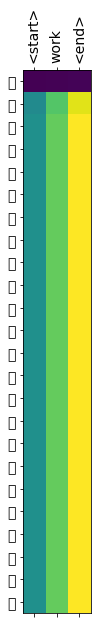

In [40]:
translate('work')